# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

# Defines functions

In [2]:
def to_np(x):
  return x.detach().cpu().numpy()

def to_torch(x):
  return torch.tensor(x).float()

# Loads the Database

In [3]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = torch.tensor(normalizedData).float()
  dataInfo = {'youngsModulus':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'costPerKg':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'massDensity':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'yieldStrength':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]},\
              'co2Kg':{'idx':4,'scaleMin':dataScaleMin[4], 'scaleMax':dataScaleMax[4]},\
              'energyKg':{'idx':5,'scaleMin':dataScaleMin[5], 'scaleMax':dataScaleMax[5]},\
              'waterKg':{'idx':6,'scaleMin':dataScaleMin[6], 'scaleMax':dataScaleMax[6]}}

  return trainingData, dataInfo, dataIdentifier, trainInfo, df
trainingData, dataInfo, dataIdentifier, trainInfo, df = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape
props = df.columns[3:].tolist()

C:\Users\luisy\AppData\Local\Temp\ipykernel_13888\405064810.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainingData = torch.tensor(normalizedData).float()


# Trains the VAE

In [4]:
latentDim, hiddenDim = 2, 250
numEpochs = 50000
epsilon=4.2e-2
epsilon=2e-2
numEpochs = 50000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}

materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)

start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate, epsilon)
print('training time : {:.2F} '.format(time.perf_counter() - start))

Iter 0 reconLoss 4.68E+01 klLoss 5.67E-03 loss 4.68E+01
Iter 500 reconLoss 2.33E-01 klLoss 6.02E-02 loss 2.93E-01
Iter 1000 reconLoss 1.08E-01 klLoss 5.91E-02 loss 1.67E-01
Iter 1500 reconLoss 7.33E-02 klLoss 5.82E-02 loss 1.32E-01
Iter 2000 reconLoss 6.02E-02 klLoss 5.65E-02 loss 1.17E-01
Iter 2500 reconLoss 4.35E-02 klLoss 5.46E-02 loss 9.81E-02
Iter 3000 reconLoss 4.59E-02 klLoss 5.28E-02 loss 9.87E-02
Iter 3500 reconLoss 3.41E-02 klLoss 5.15E-02 loss 8.56E-02
Iter 4000 reconLoss 3.73E-02 klLoss 5.02E-02 loss 8.75E-02
Iter 4500 reconLoss 3.03E-02 klLoss 4.89E-02 loss 7.91E-02
Iter 5000 reconLoss 2.83E-02 klLoss 4.79E-02 loss 7.62E-02
Iter 5500 reconLoss 2.79E-02 klLoss 4.69E-02 loss 7.48E-02
Iter 6000 reconLoss 3.14E-02 klLoss 4.57E-02 loss 7.71E-02
Iter 6500 reconLoss 2.66E-02 klLoss 4.51E-02 loss 7.17E-02
Iter 7000 reconLoss 2.86E-02 klLoss 4.37E-02 loss 7.23E-02
Iter 7500 reconLoss 2.24E-02 klLoss 4.34E-02 loss 6.58E-02
Iter 8000 reconLoss 3.74E-02 klLoss 4.33E-02 loss 8.07E-02
I

# Import the Truss

In [74]:
from examples import getExample
from trussFE import TrussFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(4)
#Changes the force
bc['forces'] = {'nodes':np.array([2]), 'fx':1.E3*torch.tensor([0.]), 'fy':1.E2*torch.tensor([125.])}

#Loads the truss in truss
truss = TrussFE(nodeXY, connectivity, bc)

# Gets the z coordinates of each material

In [75]:
vae = materialEncoder.vaeNet
#In decoded there are the decoded properties of each material
#decoded = vae.decoder(vae.encoder.z)
#In z_np are the coordinates of each real material in the latent space
z_np = to_np(vae.encoder.z)
#I get the minimum and maximum z to restrict my boundaries of latent space
z0min, z1min = 0.95*np.min(z_np, axis=0)
z0max, z1max = 1.05*np.max(z_np, axis=0)

nprops=len(props)
max_scale = np.empty(nprops)
min_scale = np.empty(nprops)

#Gets minimum and maximum of each property
for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    max_scale[idx] = materialEncoder.dataInfo[p]['scaleMax']
    min_scale[idx] = materialEncoder.dataInfo[p]['scaleMin']

# Defines objective and constraints (cost vs mass)

In [76]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3},\
               'confidenceCons': {'isOn':True, 'minconf':94}}


objectives = {'cost': {'isOn':True},\
              'mass': {'isOn':True}, \
              'co2': {'isOn':False},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Two or more entries have isOn=True')

# Defines the problem

In [77]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, truss, z_np, constraints, objectives, no, nc):
        super().__init__(n_var=8,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl=np.array([z0min, z1min, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6]),
                         xu=np.array([z0max, z1max, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]))

        self.truss=truss
        self.z_np=z_np
        self.constraints=constraints
        self.objectives=objectives


    def _evaluate(self, x, out, *args, **kwargs):

        Z = torch.zeros((1, vaeSettings['encoder']['latentDim']))
        Z[:,0]=x[0]
        Z[:,1]=x[1]

        
        matprop=np.empty(7)
        #Decodes the properties of Z
        decoded = vae.decoder(Z)
        #Scales properties
        for i in range(0,nprops): 
            matprop[i] = 10.**(min_scale[i] + decoded[:,i]*(max_scale[i] - min_scale[i]))
        
        x_tensor = torch.from_numpy(x[2:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 

        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        if(constraints['confidenceCons']['isOn']):
            zData=x[0:2]
            dist= np.linalg.norm(zData- z_np, axis = 1)
            maxDist = np.max(dist)
            distOrder = np.argsort(dist)
            confidence_level = 100.*(1.- (dist[distOrder[0]]/maxDist))
            constraints['confidenceCons']['value'] = 1 - (confidence_level/constraints['confidenceCons']['minconf'])
            con_values.append(constraints['confidenceCons']['value'])        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)        
        

problem = MyProblem(truss, z_np, constraints, objectives, no, nc)

# Defines the problem settings

In [78]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

#pop_size: Size of initial population
#n_offsprings: The number of offspring generated in each generation of the algorithm. 
#sampling: The sampling method used to generate new individuals in the offspring population.
    #In this case, FloatRandomSampling is used, which generates random floating-point values
    #in the search space to create new individuals.
#crossover: The crossover operator used to create new individuals in the offspring population.
#mutation: The mutation operator used to create new individuals in the offspring population.
#eliminate_duplicates: A flag to indicate whether duplicate individuals should be eliminated from the population or not.
algorithm = NSGA2(
    pop_size=60,
    n_offsprings=20,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.7, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination

#termination = get_termination("n_gen", 150)

termination = DefaultMultiObjectiveTermination(
    xtol=1e-5,
    cvtol=1e-6,
    ftol=0.001,
    period=15,
    n_max_gen=800,
    n_max_evals=15000
)

# Runs the solver

In [85]:
from pymoo.optimize import minimize
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print('training time : {:.2F} '.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       60 |      3 |  0.000000E+00 |  2.156612E+02 |             - |             -
     2 |       80 |      3 |  0.000000E+00 |  0.0835686443 |  0.000000E+00 |             f
     3 |      100 |      3 |  0.000000E+00 |  0.0280639811 |  0.000000E+00 |             f
     4 |      120 |      3 |  0.000000E+00 |  0.0134615296 |  0.0710217277 |             f
     5 |      140 |      3 |  0.000000E+00 |  0.0031106672 |  0.1044300706 |         ideal
     6 |      160 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0177705034 |         ideal
     7 |      180 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0486434661 |         ideal
     8 |      200 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0058134912 |         nadir
     9 |      220 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      240 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0025167848 |         ideal

    90 |     1840 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0235567140 |             f
    91 |     1860 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0101866969 |             f
    92 |     1880 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0133513104 |             f
    93 |     1900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0080256354 |         ideal
    94 |     1920 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    95 |     1940 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    96 |     1960 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    97 |     1980 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    98 |     2000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    99 |     2020 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0109013981 |             f
   100 |     2040 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0057257818 |         nadir

   182 |     3680 |     11 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   183 |     3700 |     11 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   184 |     3720 |     11 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   185 |     3740 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0001717728 |             f
   186 |     3760 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0001717728 |             f
   187 |     3780 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0001717728 |             f
   188 |     3800 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0003161491 |             f
   189 |     3820 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0069331186 |         ideal
   190 |     3840 |     12 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   191 |     3860 |     12 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   192 |     3880 |     12 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   274 |     5520 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0022507603 |             f
   275 |     5540 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0034693862 |             f
   276 |     5560 |     19 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   277 |     5580 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0007820192 |             f
   278 |     5600 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0007820192 |             f
   279 |     5620 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0007820192 |             f
   280 |     5640 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0009545054 |             f
   281 |     5660 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0009545054 |             f
   282 |     5680 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0009545054 |             f
   283 |     5700 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0034835004 |         nadir
   284 |     5720 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0004404241 |             f

training time : 30.03 


['7050-T73510', 'CFRP', '7050-T7451', 'AISI 1045 CD', '7050-T73510', 'CFRP', '2024-T3', 'CFRP', '2024-T361', 'CFRP', 'CFRP', 'CFRP', 'CFRP', 'CFRP', '2219-T87', 'CFRP', '2024-T361', 'CFRP', 'CFRP', 'AISI 1045 CD', 'CFRP', '7050-T7451', '2219-T62', '2219-T87', 'CFRP', 'CFRP', 'CFRP', 'CFRP']


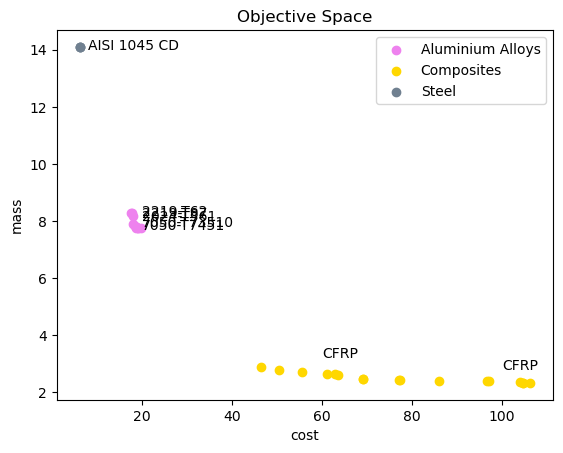

In [93]:
X = res.X
F = res.F
G = res.G


Z_res=X[:,0:2]

names = []
types = []
fig, ax = plt.subplots()
legend_dict = {}



for zData in Z_res:
    dist = np.linalg.norm(zData - z_np, axis=1)
    meanDist = np.max(dist)
    distOrder = np.argsort(dist)
    matname = dataIdentifier['name'][distOrder[0]]
    mattype = dataIdentifier['className'][distOrder[0]]
    names.append(matname)
    types.append(mattype)
    


unique_labels = list(set(types))


# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}

print(names)        
        
# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    #ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)
        
        
ax.text(8, 14, 'AISI 1045 CD')        
ax.text(20, 7.8, '7050-T73510')      
ax.text(20, 7.7, '7050-T7451')      
ax.text(20, 8.2, '2219-T62') 
ax.text(20, 8.1, '2219-T87') 
ax.text(20, 8, '2024-T361') 
ax.text(60, 3.2, 'CFRP') 
ax.text(100, 2.8, 'CFRP') 
        
#ax.text(20, 19, 'Gray Cast Iron')
#ax.text(25, 7, '1060-H14')
#ax.text(50, 6, 'CFRP')
#ax.text(100, 5, 'CFRP')
        
        
# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Multi/Multi_VAE_massvscost.png',bbox_inches='tight')
plt.show()

# Cost and co2

In [94]:
objectives2 = {'cost': {'isOn':True},\
              'mass': {'isOn':False}, \
              'co2': {'isOn':True},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Two or more entries have isOn=True')

In [96]:
class MyProblem2(ElementwiseProblem):

    def __init__(self, truss, z_np, constraints, objectives2, no, nc):
        super().__init__(n_var=8,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl=np.array([z0min, z1min, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6]),
                         xu=np.array([z0max, z1max, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]))

        self.truss=truss
        self.z_np=z_np
        self.constraints=constraints
        self.objectives=objectives2


    def _evaluate(self, x, out, *args, **kwargs):

        Z = torch.zeros((1, vaeSettings['encoder']['latentDim']))
        Z[:,0]=x[0]
        Z[:,1]=x[1]

        
        matprop=np.empty(7)
        #Decodes the properties of Z
        decoded = vae.decoder(Z)
        #Scales properties
        for i in range(0,nprops): 
            matprop[i] = 10.**(min_scale[i] + decoded[:,i]*(max_scale[i] - min_scale[i]))
        
        x_tensor = torch.from_numpy(x[2:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 

        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        if(constraints['confidenceCons']['isOn']):
            zData=x[0:2]
            dist= np.linalg.norm(zData- z_np, axis = 1)
            maxDist = np.max(dist)
            distOrder = np.argsort(dist)
            confidence_level = 100.*(1.- (dist[distOrder[0]]/maxDist))
            constraints['confidenceCons']['value'] = 1 - (confidence_level/constraints['confidenceCons']['minconf'])
            con_values.append(constraints['confidenceCons']['value'])        
        
        obj_values = []
        
        if(objectives2['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives2['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives2['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives2['water']['isOn']):
            obj_values.append(water)
            
        if(objectives2['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives2['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)        
        

problem2 = MyProblem2(truss, z_np, constraints, objectives2, no, nc)



start = time.perf_counter()
res2 = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print('training time : {:.2F} '.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       60 |      2 |  0.000000E+00 |  2.156612E+02 |             - |             -
     2 |       80 |      2 |  0.000000E+00 |  0.0829636506 |  0.000000E+00 |             f
     3 |      100 |      2 |  0.000000E+00 |  0.0314368775 |  0.000000E+00 |             f
     4 |      120 |      2 |  0.000000E+00 |  0.0154879317 |  0.000000E+00 |             f
     5 |      140 |      2 |  0.000000E+00 |  0.0051524709 |  0.000000E+00 |             f
     6 |      160 |      2 |  0.000000E+00 |  0.0006106169 |  0.000000E+00 |             f
     7 |      180 |      1 |  0.000000E+00 |  0.000000E+00 |  1.107307E+01 |         ideal
     8 |      200 |      1 |  0.000000E+00 |  0.000000E+00 |  1.888300E+01 |         ideal
     9 |      220 |      1 |  0.000000E+00 |  0.000000E+00 |  9.0313941393 |         ideal
    10 |      240 |      2 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal

    92 |     1880 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1530368638 |         ideal
    93 |     1900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    94 |     1920 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0869882591 |             f
    95 |     1940 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    96 |     1960 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    97 |     1980 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    98 |     2000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.4828547019 |         ideal
    99 |     2020 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0075481134 |             f
   100 |     2040 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0249185978 |         ideal
   101 |     2060 |      6 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   102 |     2080 |      6 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   183 |     3700 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0033748812 |             f
   184 |     3720 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0010266788 |             f
   185 |     3740 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0010266788 |             f
   186 |     3760 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0017187956 |             f
   187 |     3780 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0058239817 |             f
   188 |     3800 |     21 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   189 |     3820 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0023045918 |             f
   190 |     3840 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0042727063 |             f
   191 |     3860 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0005420614 |             f
   192 |     3880 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0005420614 |             f
   193 |     3900 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0024042784 |             f

   276 |     5560 |     43 |  0.000000E+00 |  0.000000E+00 |  0.0006228536 |             f
   277 |     5580 |     45 |  0.000000E+00 |  0.000000E+00 |  0.0036672435 |         ideal
   278 |     5600 |     46 |  0.000000E+00 |  0.000000E+00 |  0.0000736052 |             f
   279 |     5620 |     46 |  0.000000E+00 |  0.000000E+00 |  0.0006939990 |             f
   280 |     5640 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0007073932 |             f
   281 |     5660 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0007510524 |             f
   282 |     5680 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0008179819 |             f
   283 |     5700 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0010558506 |             f
   284 |     5720 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0010558506 |             f
   285 |     5740 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0010760754 |             f
   286 |     5760 |     43 |  0.000000E+00 |  0.000000E+00 |  0.0152522351 |         ideal

   369 |     7420 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0019385710 |             f
   370 |     7440 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0031449826 |             f
   371 |     7460 |     60 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   372 |     7480 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0000456613 |             f
   373 |     7500 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0000787735 |             f
training time : 29.17 


['AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 4130 norm', 'AISI 413

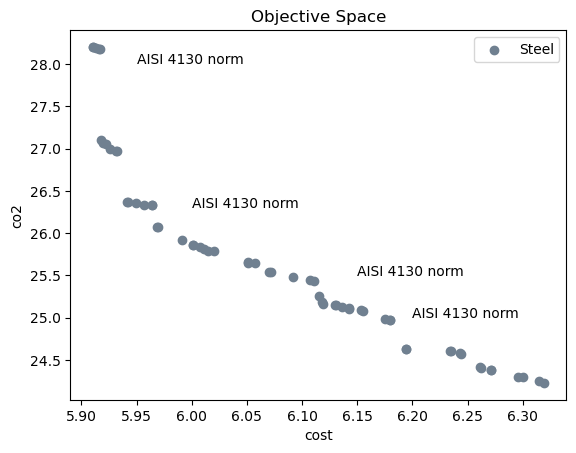

In [100]:
X2 = res2.X
F2 = res2.F
G2 = res2.G


Z_res2=X2[:,0:2]

names = []
types = []
fig, ax = plt.subplots()
legend_dict = {}



for zData in Z_res2:
    dist = np.linalg.norm(zData - z_np, axis=1)
    meanDist = np.max(dist)
    distOrder = np.argsort(dist)
    matname = dataIdentifier['name'][distOrder[0]]
    mattype = dataIdentifier['className'][distOrder[0]]
    names.append(matname)
    types.append(mattype)
    


unique_labels = list(set(types))


# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}

print(names)        
        
# add scatter plot for each unique label
for i, (x, y) in enumerate(F2):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    #ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)
        
        
ax.text(5.95, 28, 'AISI 4130 norm') 
ax.text(6, 26.3, 'AISI 4130 norm') 
ax.text(6.15, 25.5, 'AISI 4130 norm') 
ax.text(6.2, 25, 'AISI 4130 norm') 
        
# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives2[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Multi/Multi_VAE_costvsco2.png',bbox_inches='tight')
plt.show()